- (c) Ken-ichi Fukui, 2020/01/17
-  MIT License

## ナイーブベイズ分類器によるゴルフプレイデータの識別とROC,AUCによる評価
- データweather.nominal.arffは本プログラムと同じフォルダ内に置いておく

In [37]:
%matplotlib inline
import numpy as np
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from scipy.io import arff
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB

### arffデータの読み込み

In [38]:
f = open("weather.nominal.arff", "r", encoding="utf-8")
data, meta = arff.loadarff(f)
data, meta

(array([(b'sunny', b'hot', b'high', b'FALSE', b'no'),
        (b'sunny', b'hot', b'high', b'TRUE', b'no'),
        (b'overcast', b'hot', b'high', b'FALSE', b'yes'),
        (b'rainy', b'mild', b'high', b'FALSE', b'yes'),
        (b'rainy', b'cool', b'normal', b'FALSE', b'yes'),
        (b'rainy', b'cool', b'normal', b'TRUE', b'no'),
        (b'overcast', b'cool', b'normal', b'TRUE', b'yes'),
        (b'sunny', b'mild', b'high', b'FALSE', b'no'),
        (b'sunny', b'cool', b'normal', b'FALSE', b'yes'),
        (b'rainy', b'mild', b'normal', b'FALSE', b'yes'),
        (b'sunny', b'mild', b'normal', b'TRUE', b'yes'),
        (b'overcast', b'mild', b'high', b'TRUE', b'yes'),
        (b'overcast', b'hot', b'normal', b'FALSE', b'yes'),
        (b'rainy', b'mild', b'high', b'TRUE', b'no')],
       dtype=[('outlook', 'S8'), ('temperature', 'S4'), ('humidity', 'S6'), ('windy', 'S5'), ('play', 'S3')]),
 Dataset: weather.symbolic
 	outlook's type is nominal, range is ('sunny', 'overcast', 'rainy

### LabelEncoderを使ってラベル特徴を数値に変換
例えば，変数outlookの値{sunny, overcast, rainy}は，{0,1,2}に変換される

In [39]:
le = [LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder(),LabelEncoder()]
for idx,attr in enumerate(meta):
    le[idx].fit(list(meta[attr][1]))

class_array = np.array([])
feature_array = np.zeros((0,4))

for x in data:
    w = list(x)
    class_array = np.append(class_array, le[-1].transform(w[-1].decode("utf-8").split()))
    w.pop(-1)
    for idx in range(0, len(w)):
        w[idx] = le[idx].transform(w[idx].decode("utf-8").split())
    temp = np.array(w)
    feature_array = np.append(feature_array, np.ravel(temp).reshape(1,-1), axis=0)

feature_array

array([[2., 1., 0., 0.],
       [2., 1., 0., 1.],
       [0., 1., 0., 0.],
       [1., 2., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 1.],
       [0., 0., 1., 1.],
       [2., 2., 0., 0.],
       [2., 0., 1., 0.],
       [1., 2., 1., 0.],
       [2., 2., 1., 1.],
       [0., 2., 0., 1.],
       [0., 1., 1., 0.],
       [1., 2., 0., 1.]])

### OneHotEncoderを使ってLabelEncoderで数値化したラベル特徴をさらに変換
sunnyは{1,0,0}，overcastは{0,1,0},rainyは{0,0,1}に変換される

順序を持たないラベル変数の場合はLabelEncoderだけでは不適切

In [40]:
enc = OneHotEncoder(categories='auto')
feature_encoded = enc.fit_transform(feature_array).toarray()
feature_encoded

array([[0., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 0., 0., 1., 1., 0.],
       [0., 1., 0., 1., 0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 0., 1., 1., 0., 1., 0.],
       [0., 0., 1., 1., 0., 0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 1., 0.],
       [0., 0., 1., 0., 0., 1., 0., 1., 0., 1.],
       [1., 0., 0., 0., 0., 1., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 0., 1., 1., 0., 0., 1.]])

### 1つ抜き交差検証（Leave-one-out cross-validation）
全N個のデータから1個を除いた(N-1)個を学習データとしてモデルを学習し，残りの1個でテストを行う．これをN回繰り返す．

In [41]:
y_train_post_list,y_train_list,y_test_post_list,y_test_list = [],[],[],[]

loo = LeaveOneOut()
for train_index, test_index in loo.split(feature_encoded):
    X_train, X_test = feature_encoded[train_index], feature_encoded[test_index]
    y_train, y_test = class_array[train_index], class_array[test_index]

    # =====================================================================
    # ベルヌーイナイーブベイズ（BernoulliNB）を使用する．
    # alpha(>0)はスムージングのパラメータ．
    # ただし，スライドの等価標本サイズmとの関係はalpha=m/n
    # http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes
    # fit_prior=Trueに指定すると学習データから事前確率を求める．
    # class_priorは，class_prior=[0.2,0.8]の形で事前確率を指定する．fit_prior=Falseのときに有効．
    clf = BernoulliNB(alpha=0.1, class_prior=[0.7,0.3], fit_prior=False)
    clf.fit(X_train,y_train)

    # =====================================================================
    # 学習データとテストデータに対する各クラスの事後確率を算出
    posterior_trn = clf.predict_proba(X_train)
    posterior_tst = clf.predict_proba(X_test)

    # テストデータの正解クラスと事後確率を出力
    print("True Label:", y_test)
    print("Posterior Probability:", posterior_tst)

    # 正解クラスと事後確率を保存
    y_train_post_list.extend(posterior_trn[:,[1]])
    y_train_list.extend(y_train)
    y_test_post_list.append(posterior_tst[0][1])
    y_test_list.extend(y_test)

True Label: [0.]
Posterior Probability: [[0.85409769 0.14590231]]
True Label: [0.]
Posterior Probability: [[0.98803977 0.01196023]]
True Label: [1.]
Posterior Probability: [[0.52900682 0.47099318]]
True Label: [1.]
Posterior Probability: [[0.94442502 0.05557498]]
True Label: [1.]
Posterior Probability: [[0.13106095 0.86893905]]
True Label: [0.]
Posterior Probability: [[1.27054451e-04 9.99872946e-01]]
True Label: [1.]
Posterior Probability: [[0.02965118 0.97034882]]
True Label: [0.]
Posterior Probability: [[0.68291583 0.31708417]]
True Label: [1.]
Posterior Probability: [[0.42873711 0.57126289]]
True Label: [1.]
Posterior Probability: [[0.17177252 0.82822748]]
True Label: [1.]
Posterior Probability: [[0.92989151 0.07010849]]
True Label: [1.]
Posterior Probability: [[0.7749193 0.2250807]]
True Label: [1.]
Posterior Probability: [[0.01352228 0.98647772]]
True Label: [0.]
Posterior Probability: [[0.82916301 0.17083699]]


### ROC曲線の描画とAUCの算出

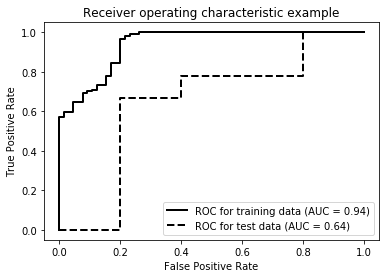

In [42]:
fpr_trn, tpr_trn, thresholds_trn = roc_curve(y_train_list, y_train_post_list)
roc_auc_trn = auc(fpr_trn, tpr_trn)
plt.plot(fpr_trn, tpr_trn, 'k--',label='ROC for training data (AUC = %0.2f)' % roc_auc_trn, lw=2, linestyle="-")

fpr_tst, tpr_tst, thresholds_tst = roc_curve(y_test_list, y_test_post_list)
roc_auc_tst = auc(fpr_tst, tpr_tst)
plt.plot(fpr_tst, tpr_tst, 'k--',label='ROC for test data (AUC = %0.2f)' % roc_auc_tst, lw=2, linestyle="--")

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.show()